## Code description
This code is meant for analyzing Jupiter X-ray data on a per ScW basis. It plots the lightcurves of Jupiter for the various energy ranges.

## Begin code

In [1]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.time import Time

## 15 - 30 keV (ISGRI)

Distribution of Jupiter ScWs

<Figure size 1000x600 with 0 Axes>

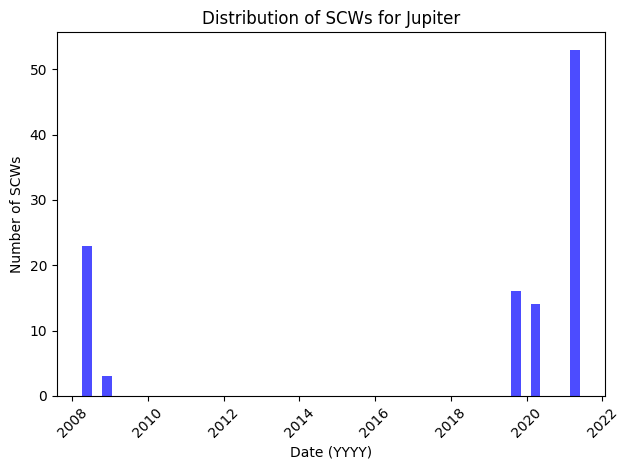

<Figure size 1000x600 with 0 Axes>

In [2]:
scwdates = []

for file in os.listdir('../data/Jupiter/15-30keV/Images/'):
    if file.endswith('.fits'):
        with fits.open(os.path.join('../data/Jupiter/15-30keV/Images/', file)) as hdul:
            scwdates.append(hdul[2].header['DATE-OBS'])

scwdates = [Time(date, format='isot').datetime for date in scwdates]

plt.figure()
plt.hist(scwdates, bins=50, color='blue', alpha=0.7)
plt.xlabel('Date (YYYY)')
plt.ylabel('Number of SCWs')
plt.title('Distribution of SCWs for Jupiter')
plt.xticks(rotation=45)
plt.tight_layout()
plt.figure(figsize=(10, 6))


From the FITS files

In [61]:
import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

In [62]:
# ISGRI: 15 - 30 keV
cr1, vr1, sg1, xp1, acr1, avr1, cr1_cpsf, cr1_psf, err1_cpsf, err1_psf, date1, offset1 = loadJupiterIMG(path='../data/Jupiter/15-30keV/Images', scw_path='../data/jupiter_table.dat')
lc1, lc1_err, lc1_date = loadJupiterLC()

Do some plotting

Max value of cr1: 4.559806823730469
Index of max value of cr1: 30
File name of max value of cr1: ../data/Jupiter/15-30keV/Images/066800490010.001mosaic.fits
Date of max value of cr1: 2008-04-04 10:47:25


/home/hthums/micromamba/envs/jupiter_xray/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/hthums/micromamba/envs/jupiter_xray/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/hthums/micromamba/envs/jupiter_xray/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/hthums/micromamba/envs/jupiter_xray/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/hthums/micromamba/envs/jupiter_xray/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


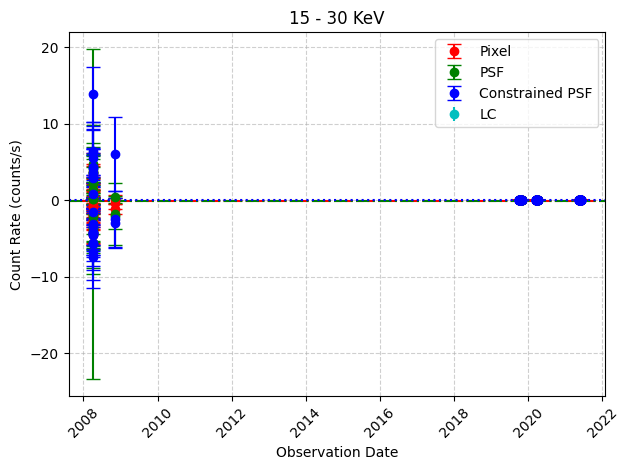

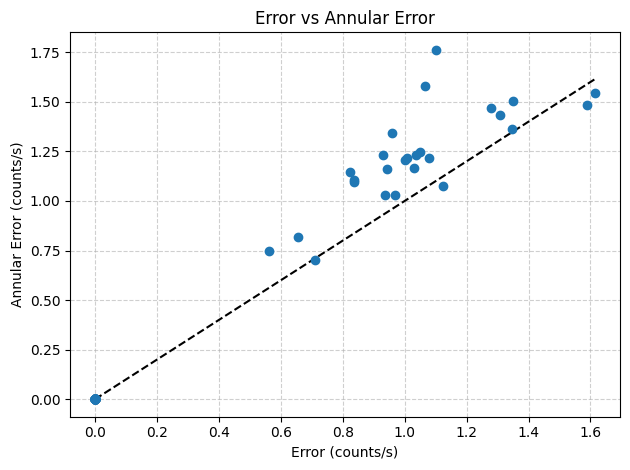

In [102]:
import matplotlib.pyplot as plt

img_times1 = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S") for date in date1]
lc_times1 = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.%f") for date in lc1_date]

# Calculate averages and standard deviations
avg_cr1 = np.mean(cr1)
std_cr1 = np.std(cr1)
avg_psf1 = np.mean(cr1_psf)
std_psf1 = np.std(cr1_psf)
avg_cpsf1 = np.mean(cr1_cpsf)
std_cpsf1 = np.std(cr1_cpsf)

avg_lc1 = np.mean(lc1)
std_lc1 = np.std(lc1)

# Max value
print("Max value of cr1:", np.max(cr1))
print("Index of max value of cr1:", np.argmax(cr1))
files = glob.glob(f'../data/Jupiter/15-30keV/Images/*')
max_file = files[np.argmax(cr1)]
print("File name of max value of cr1:", max_file)
print("Date of max value of cr1:", img_times1[np.argmax(cr1)])

# Plot count rate over time with errorbars and std region
plt.figure()

plt.errorbar(img_times1, cr1, yerr=np.sqrt(vr1), color='r', fmt='o', capsize=5, label='Pixel')
plt.errorbar(img_times1, cr1_psf, yerr=err1_psf, color='g', fmt='o', capsize=5, label='PSF')
plt.errorbar(img_times1, cr1_cpsf, yerr=err1_cpsf, color='b', fmt='o', capsize=5, label='Constrained PSF')
plt.errorbar(lc_times1, lc1, yerr=lc1_err, color='c', fmt='o', capsize=5, label='LC')

plt.axhline(avg_cr1, color='r', linestyle='--')
plt.axhline(avg_psf1, color='g', linestyle='-.')
plt.axhline(avg_cpsf1, color='b', linestyle=':')
plt.axhline(avg_lc1, color='c', linestyle='-.')

plt.xlabel("Observation Date")
plt.ylabel("Count Rate (counts/s)")
plt.title("15 - 30 KeV")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()


# Plot error vs annular error
plt.figure()

# straight line
x = np.linspace(0, np.max(np.sqrt(vr1)), 100)
y = x
plt.plot(x, y, color='k', linestyle='--', label='y=x')

plt.errorbar(np.sqrt(vr1), np.sqrt(avr1), fmt='o', capsize=5)

plt.xlabel("Error (counts/s)")
plt.ylabel("Annular Error (counts/s)")
plt.title("Error vs Annular Error")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

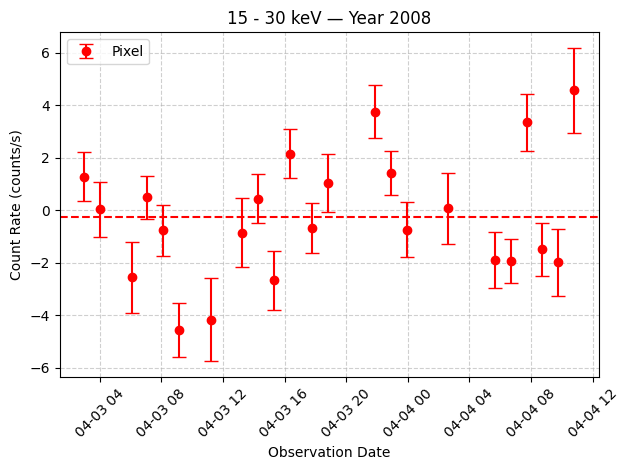

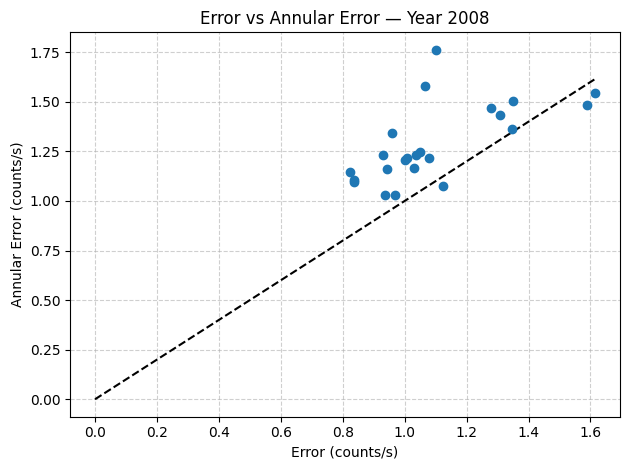

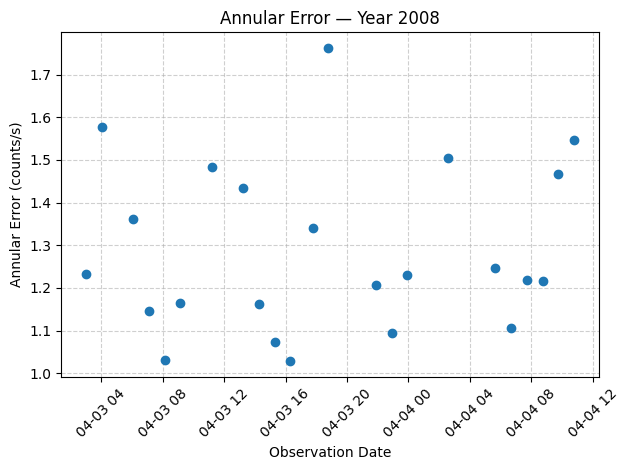

In [103]:

# Convert strings to datetime
img_times1 = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S") for date in date1]
lc_times1 = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.%f") for date in lc1_date]

# Filter data for year 2008
img_filter = [i.year == 2008 and i.month == 4 for i in img_times1]
lc_filter = [i.year == 2008 and i.month == 4 for i in lc_times1]

# Apply filter to all relevant arrays
img_times1_2008 = [t for t, keep in zip(img_times1, img_filter) if keep]
cr1_2008 = [v for v, keep in zip(cr1, img_filter) if keep]
cr1_psf_2008 = [v for v, keep in zip(cr1_psf, img_filter) if keep]
cr1_cpsf_2008 = [v for v, keep in zip(cr1_cpsf, img_filter) if keep]
vr1_2008 = [v for v, keep in zip(vr1, img_filter) if keep]

err1_psf_2008 = [v for v, keep in zip(err1_psf, img_filter) if keep]
err1_cpsf_2008 = [v for v, keep in zip(err1_cpsf, img_filter) if keep]

avr1_2008 = [v for v, keep in zip(avr1, img_filter) if keep]

lc_times1_2008 = [t for t, keep in zip(lc_times1, lc_filter) if keep]
lc1_2008 = [v for v, keep in zip(lc1, lc_filter) if keep]
lc1_err_2008 = [v for v, keep in zip(lc1_err, lc_filter) if keep]

# Calculate averages
avg_cr1 = np.mean(cr1_2008)
avg_psf1 = np.mean(cr1_psf_2008)
avg_cpsf1 = np.mean(cr1_cpsf_2008)
avg_lc1 = np.mean(lc1_2008)

# Plot count rate over time with errorbars and std region
plt.figure()
plt.errorbar(img_times1_2008, cr1_2008, yerr=np.sqrt(vr1_2008), color='r', fmt='o', capsize=5, label='Pixel')
#plt.errorbar(img_times1_2008, cr1_psf_2008, yerr=err1_psf_2008, color='g', fmt='o', capsize=5, label='PSF')
#plt.errorbar(img_times1_2008, cr1_cpsf_2008, yerr=err1_cpsf_2008, color='b', fmt='o', capsize=5, label='Constrained PSF')
#plt.errorbar(lc_times1_2008, lc1_2008, yerr=lc1_err_2008, color='c', fmt='o', capsize=5, label='LC')

plt.axhline(avg_cr1, color='r', linestyle='--')
#plt.axhline(avg_psf1, color='g', linestyle='-.')
#plt.axhline(avg_cpsf1, color='b', linestyle=':')
#plt.axhline(avg_lc1, color='c', linestyle='-.')

plt.xlabel("Observation Date")
plt.ylabel("Count Rate (counts/s)")
plt.title("15 - 30 keV — Year 2008")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# Plot error vs annular error
plt.figure()
x = np.linspace(0, np.max(np.sqrt(vr1_2008)), 100)
plt.plot(x, x, color='k', linestyle='--', label='y = x')
plt.errorbar(np.sqrt(vr1_2008), np.sqrt(avr1_2008), fmt='o', capsize=5)
plt.xlabel("Error (counts/s)")
plt.ylabel("Annular Error (counts/s)")
plt.title("Error vs Annular Error — Year 2008")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Plot annular error over time
plt.figure()
plt.errorbar(img_times1_2008, np.sqrt(avr1_2008), fmt='o', capsize=5)
plt.xlabel("Observation Date")
plt.ylabel("Annular Error (counts/s)")
plt.title("Annular Error — Year 2008")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

Let's plot S/N or significance

Images corresponding to S/N > 3:
Date: 2008-04-04 07:42:49, S/N: 3.099009151405778
File name: ../data/Jupiter/15-30keV/Images/236600210010.001mosaic.fits
Max value: 4.559806823730469
Index of max value: 21
Date of max value: 2008-04-04 07:42:49

Date: 2008-04-03 21:52:21, S/N: 3.7501108193207795
File name: ../data/Jupiter/15-30keV/Images/215200060010.001mosaic.fits
Max value: 4.559806823730469
Index of max value: 22
Date of max value: 2008-04-03 21:52:21



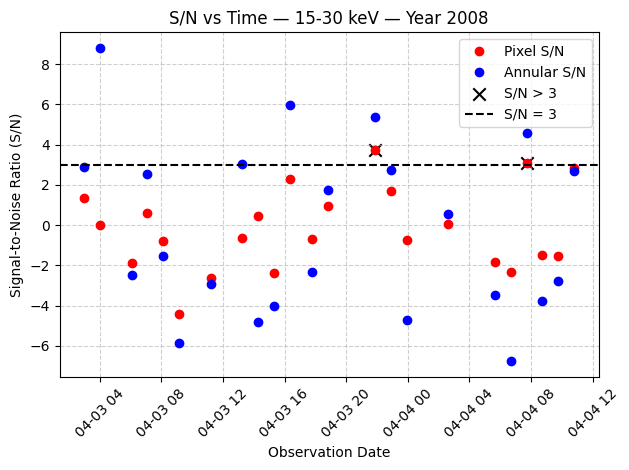

In [104]:
snr_cr1_2008 = np.array(cr1_2008) / np.sqrt(vr1_2008)
annular_snr_cr1_2008 = np.array(cr1_cpsf_2008) / np.sqrt(avr1_2008)

plt.figure()
plt.plot(img_times1_2008, snr_cr1_2008, 'o', color='r', label='Pixel S/N')
plt.plot(img_times1_2008, annular_snr_cr1_2008, 'o', color='b', label='Annular S/N')

outliers_idx = [i for i, snr in enumerate(snr_cr1_2008) if snr > 3]
plt.scatter(
    [img_times1_2008[i] for i in outliers_idx],
    [snr_cr1_2008[i] for i in outliers_idx],
    marker='x',
    color='k',
    s=80,
    label='S/N > 3'
)

plt.axhline(3, color='k', linestyle='--', label='S/N = 3')

plt.xlabel("Observation Date")
plt.ylabel("Signal-to-Noise Ratio (S/N)")
plt.title("S/N vs Time — 15-30 keV — Year 2008")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

print("Images corresponding to S/N > 3:")
for idx in outliers_idx:
    print(f"Date: {img_times1_2008[idx]}, S/N: {snr_cr1_2008[idx]}")
    print(f"File name: {files[idx]}")
    print(f"Max value: {np.max(cr1_2008)}")
    print(f"Index of max value: {idx}")
    print(f"Date of max value: {img_times1_2008[idx]}")
    print()

Total points: 23
Observed points beyond 3σ: 3
Expected points beyond 3σ: 0.06
Observed fraction: 13.04%
Expected fraction: 0.27%


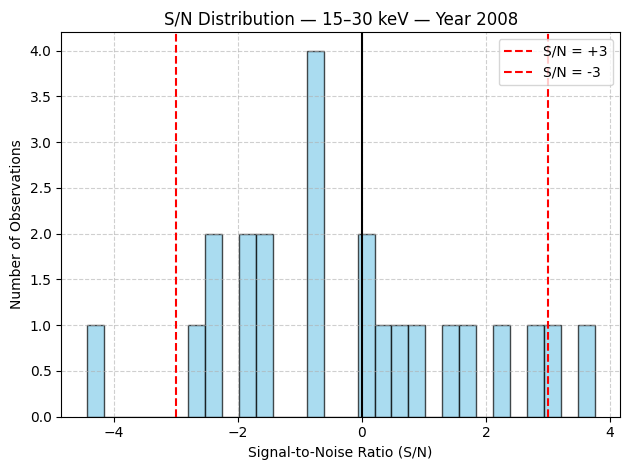

In [93]:
plt.figure()
plt.hist(snr_cr1_2008, bins=30, color='skyblue', edgecolor='k', alpha=0.7)
plt.axvline(0, color='k', linestyle='-')
plt.axvline(3, color='r', linestyle='--', label='S/N = +3')
plt.axvline(-3, color='r', linestyle='--', label='S/N = -3')
plt.xlabel("Signal-to-Noise Ratio (S/N)")
plt.ylabel("Number of Observations")
plt.title("S/N Distribution — 15–30 keV — Year 2008")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()


snr = np.array(cr1_2008) / np.sqrt(vr1_2008)
outliers = (snr > 3) | (snr < -3)
n_outliers = np.sum(outliers)

n_total = len(snr)
n_expected = 0.0027 * n_total # theoretical fraction of outliers in a normal distribution

print(f"Total points: {n_total}")
print(f"Observed points beyond 3σ: {n_outliers}")
print(f"Expected points beyond 3σ: {n_expected:.2f}")
print(f"Observed fraction: {n_outliers/n_total *100:.2f}%")
print(f"Expected fraction: 0.27%")


Convert the excesses to fluxes using Crab countrate in 2008

In [112]:
import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

Flux values for S/N > 3:
Date: 2008-04-04 07:42:49, Photon Flux: 0.004685324323447447 +- 0.0015118781825223335, Energy Flux: 1.5535695732379573e-10 +- 5.0131170878705676e-11
File name: ../data/Jupiter/15-30keV/Images/236600210010.001mosaic.fits

Date: 2008-04-03 21:52:21, Photon Flux: 0.00525857476609071 +- 0.0014022451653957105, Energy Flux: 1.7436491459750855e-10 +- 4.649593651984117e-11
File name: ../data/Jupiter/15-30keV/Images/215200060010.001mosaic.fits

Average fluxes:
Photon Flux: -0.00034675515303029744 +- 0.003224841585670969
Energy Flux: -1.1497779404840897e-11 +- 1.069299672797146e-10


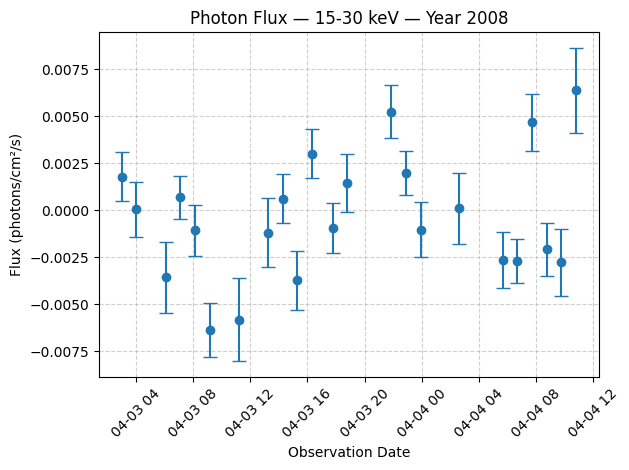

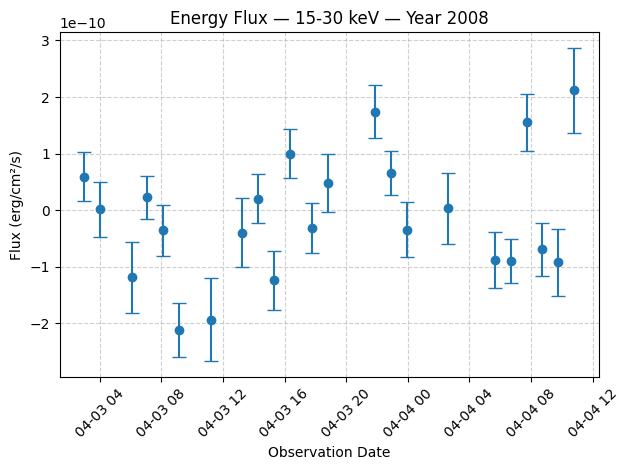

In [180]:
# 2008: 178.74 +- 1.96 counts/s
ph_flux1, ph_flux1_err, erg_flux1, erg_flux1_err, flux1_date = cr2flux(cr1_2008, vr1_2008, img_times1_2008, [178.74], [1.96], [2008])

plt.figure()
plt.errorbar(flux1_date, ph_flux1, yerr=ph_flux1_err, fmt='o', capsize=5, label='Photon Flux')
plt.xlabel("Observation Date")
plt.ylabel("Flux (photons/cm²/s)")
plt.title("Photon Flux — 15-30 keV — Year 2008")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.figure()
plt.errorbar(flux1_date, erg_flux1, yerr=erg_flux1_err, fmt='o', capsize=5, label='Energy Flux')
plt.xlabel("Observation Date")
plt.ylabel("Flux (erg/cm²/s)")
plt.title("Energy Flux — 15-30 keV — Year 2008")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Values of the fluxes for the points above 3σ

print("Flux values for S/N > 3:")
for idx in outliers_idx:
    print(f"Date: {flux1_date[idx]}, Photon Flux: {ph_flux1[idx]} +- {ph_flux1_err[idx]}, Energy Flux: {erg_flux1[idx]} +- {erg_flux1_err[idx]}")
    print(f"File name: {files[idx]}")
    print()

print("Average fluxes:")
print(f"Photon Flux: {np.mean(ph_flux1)} +- {np.std(ph_flux1)}")
print(f"Energy Flux: {np.mean(erg_flux1)} +- {np.std(erg_flux1)}")

Upper limit for the fluxes

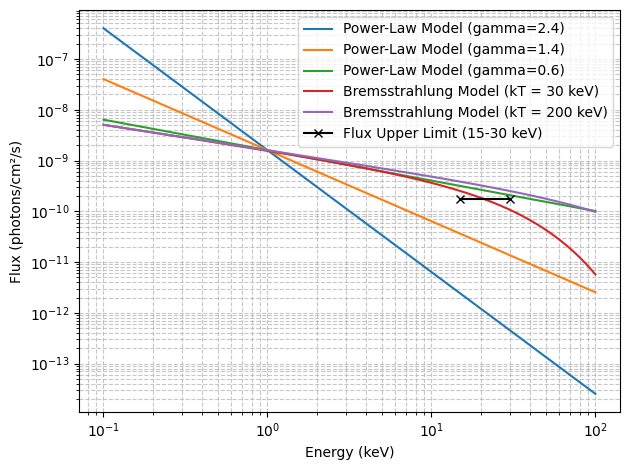

In [190]:
E = np.logspace(-1, 2, 500) 

def power_law(E, A=1.0, gamma=1.0):
    return A * E**(-gamma) * 1.60218e-9

def bremsstrahlung(E, A=1.0, kT=1.0):
    return A * np.exp(-E / kT) / np.sqrt(E) * 1.60218e-9

# Upper limit (flux measurement in 15-30 keV range)
upper_limit_flux = 1.7436491459750855e-10  
E_min, E_max = 15, 30

# Plot
plt.figure()

plt.plot(E, power_law(E, gamma=2.4), label="Power-Law Model (gamma=2.4)")
plt.plot(E, power_law(E, gamma=1.4), label="Power-Law Model (gamma=1.4)")
plt.plot(E, power_law(E, gamma=0.6), label="Power-Law Model (gamma=0.6)")
plt.plot(E, bremsstrahlung(E, kT=30.0), label="Bremsstrahlung Model (kT = 30 keV)")
plt.plot(E, bremsstrahlung(E, kT=200.0), label="Bremsstrahlung Model (kT = 200 keV)")

plt.plot([15, 30], [upper_limit_flux, upper_limit_flux] , color="black", label="Flux Upper Limit (15-30 keV)", marker='x', markersize=6)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy (keV)")
plt.ylabel("Flux (photons/cm²/s)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.tight_layout()

## 30 - 60 keV (ISGRI)

## 3 - 15 keV (JEM-X)